/tmp/ipykernel_47/454174833.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wellbeing = df.groupby(['age_group','gender'])['wellbeing_index'].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this wa

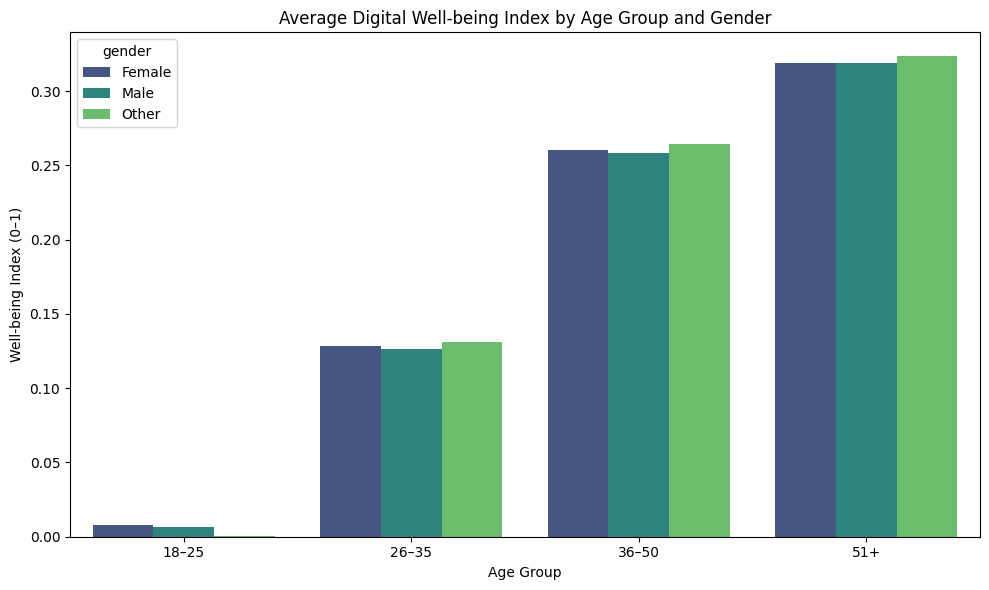

              precision    recall  f1-score   support

     At_Risk       1.00      0.58      0.73        19
     Healthy       0.96      0.97      0.97       100
    Stressed       0.99      1.00      1.00      1381

    accuracy                           0.99      1500
   macro avg       0.98      0.85      0.90      1500
weighted avg       0.99      0.99      0.99      1500



/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


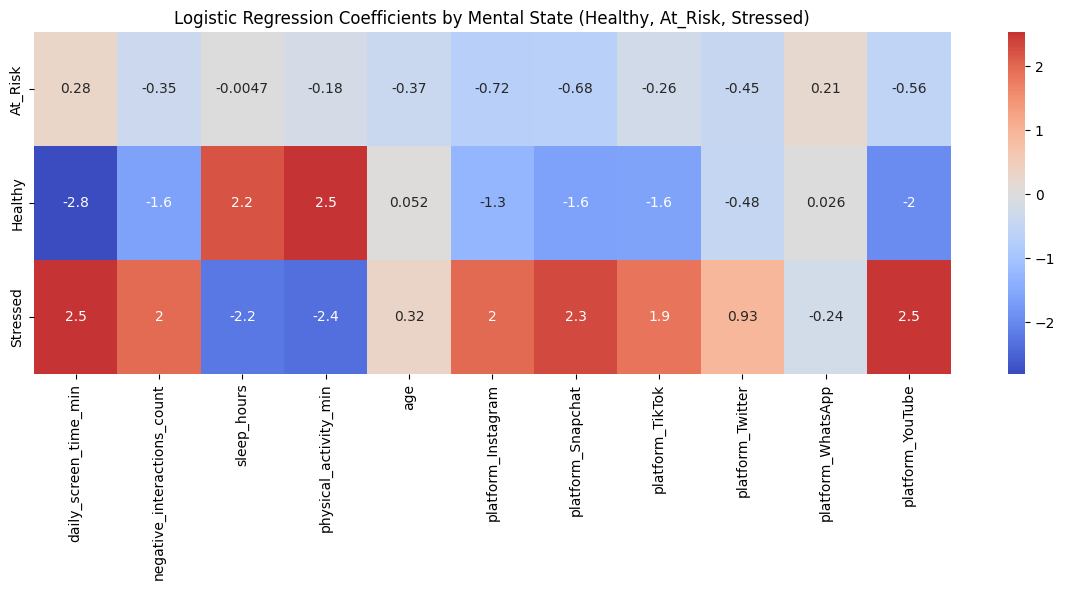

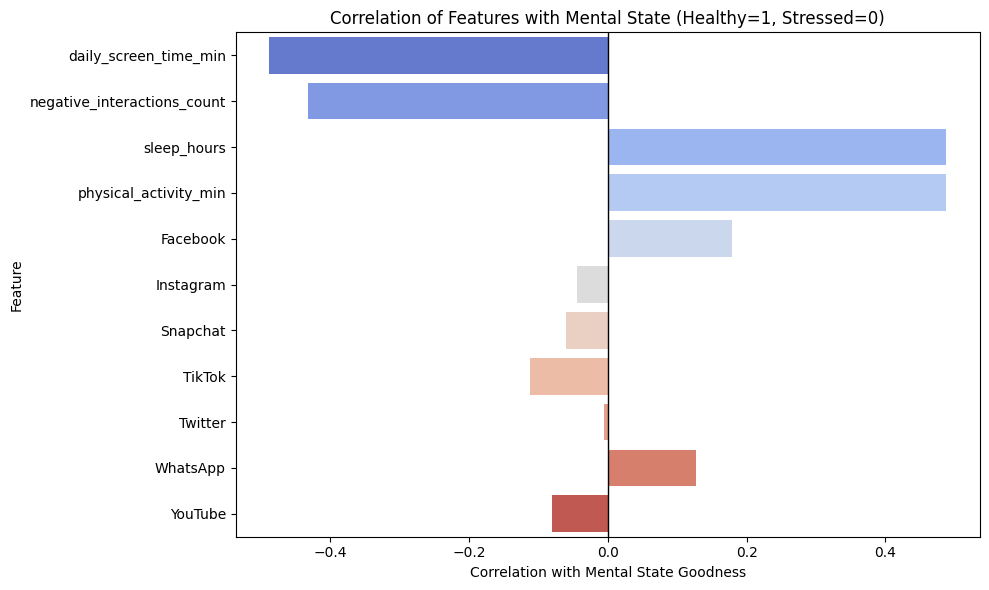

In [3]:
# 1. Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import os

os.makedirs("Advanced_insights", exist_ok=True)

# 2. Load Dataset

df = pd.read_csv("/kaggle/input/mental-health-social-media-correct/mental_health_social_media_correct.csv")

# 3. Composite Digital Well‑being Index (DWI)

df['wellbeing_index'] = (
    (df['daily_screen_time_min']/600 * -1) +
    (df['negative_interactions_count']/10 * -1) +
    (df['sleep_hours']/9) +
    (df['physical_activity_min']/60)
) / 4

df['age_group'] = pd.cut(df['age'], bins=[18,25,35,50,100], labels=['18–25','26–35','36–50','51+'])


# 4. Graph 1: Well‑being Index by Age Group and Gender

wellbeing = df.groupby(['age_group','gender'])['wellbeing_index'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=wellbeing, x='age_group', y='wellbeing_index', hue='gender', palette='viridis')
plt.title("Average Digital Well‑being Index by Age Group and Gender")
plt.xlabel("Age Group")
plt.ylabel("Well‑being Index (0–1)")
plt.tight_layout()
plt.savefig("Advanced_insights/wellbeing_index_age_gender.png", dpi=300, bbox_inches='tight')
plt.show()

# 5. Multinomial Logistic Regression (Healthy, At_Risk, Stressed)

X = df[[ 
    "daily_screen_time_min",        # screen time
    "negative_interactions_count",  # negative interactions
    "sleep_hours",                  # sleep
    "physical_activity_min",        # physical activity
    "age",                          # age
    "platform"                      # categorical, will need encoding
]]

# Encode categorical variable (platform only)
X = pd.get_dummies(X, drop_first=True)

y = df["mental_state"]   # Healthy, At_Risk, Stressed

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train multinomial model
model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 6. Graph 2: Coefficient Heatmap (all classes)

coefficients = pd.DataFrame(model.coef_, columns=X.columns, index=model.classes_)

plt.figure(figsize=(12,6))
sns.heatmap(coefficients, annot=True, cmap="coolwarm", center=0)
plt.title("Logistic Regression Coefficients by Mental State (Healthy, At_Risk, Stressed)")
plt.tight_layout()
plt.savefig("Advanced_insights/logreg_coefficients_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# The "At_Risk" class is excluded because it contains too few observations
# compared to "Healthy" and "Stressed". Including it could bias the results
# and make interpretation unstable. Focusing only on Healthy vs Stressed
# provides a more robust and readable comparison.

# For Graph 3, Pearson correlation is used.

# - It is a linear measure that indicates the strength and direction of the
#   association between an explanatory variable and the target (mental_state_num).
# - A positive value means the variable is associated with a better mental state (Healthy),
#   while a negative value indicates an association with a more stressed state.
# - Pearson correlation is appropriate here because the variables are quantitative
#   or binary (dummy variables), and the goal is a simple, intuitive measure of association.

# 7. Correlation Analysis (2 classes : Healthy=1, Stressed=0)

# Map mental_state to numeric (binary for correlation)
mental_map = {"Healthy":1, "Stressed":0}
df['mental_state_num'] = df['mental_state'].map(mental_map)

features = [
    "daily_screen_time_min",
    "negative_interactions_count",
    "sleep_hours",
    "physical_activity_min"
]

platforms = pd.get_dummies(df['platform'], drop_first=False)
df = pd.concat([df, platforms], axis=1)

correlations = df[features + list(platforms.columns) + ['mental_state_num']].corr()['mental_state_num'].drop('mental_state_num')

# 8. Graph 3: Diverging Bar Chart of Correlations

plt.figure(figsize=(10,6))
sns.barplot(x=correlations.values, y=correlations.index, palette="coolwarm", orient="h")
plt.axvline(0, color='black', linewidth=1)
plt.title("Correlation of Features with Mental State (Healthy=1, Stressed=0)")
plt.xlabel("Correlation with Mental State Goodness")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("Advanced_insights/feature_correlation_diverging.png", dpi=300, bbox_inches='tight')
plt.show()

